In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# 1. Drive'ı Bağla
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- AYARLAR ---
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/DerinOgrenmeProje'
# Model dosyasını sadece ağırlık (weight) olarak kullanacağız
MODEL_PATH = os.path.join(BASE_PATH, 'final_model.h5')
TOKENIZER_PATH = os.path.join(BASE_PATH, 'tokenizer.pkl')
RESIM_KLASORU = os.path.join(BASE_PATH, 'Flickr8k_Data/Images')
MAX_LENGTH = 34
VOCAB_SIZE = 8766 # Eğitimde bulduğumuz sayı (Değişmez)

# 2. Dosyaları ve Modeli Yükle
print("Sistem dosyaları yükleniyor...")

if os.path.exists(TOKENIZER_PATH) and os.path.exists(MODEL_PATH):
    # A) Sözlüğü Yükle
    with open(TOKENIZER_PATH, 'rb') as f:
        tokenizer = pickle.load(f)
    print("✅ Tokenizer (Sözlük) yüklendi.")

    # B) Modeli TEKRAR İNŞA ET (Load Model hatasını aşmak için iskeleti kuruyoruz)
    print("🛠️ Model iskeleti oluşturuluyor...")

    # --- Model Mimarisi (Eğitimdeki kodun aynısı) ---
    inputs1 = Input(shape=(4096,), name="Goruntu_Girdisi")
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(MAX_LENGTH,), name="Metin_Girdisi")
    se1 = Embedding(VOCAB_SIZE, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # ------------------------------------------------

    # C) Hafızayı (Ağırlıkları) Yükle
    print("🧠 Hafıza (Weights) yükleniyor...")
    model.load_weights(MODEL_PATH)
    print("✅ Eğitilmiş Model Hazır!")

    # D) VGG16 Hazırla
    vgg_model = VGG16()
    feature_extractor = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    print("✅ Görsel İşlemci (VGG16) hazır.")

else:
    print("❌ HATA: Dosyalar bulunamadı! Lütfen BASE_PATH yolunu kontrol et.")

# --- 3. YARDIMCI FONKSİYONLAR ---

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break
    return in_text.replace('startseq ', '').replace(' endseq', '')

def test_et(resim_yolu):
    try:
        # Resmi Göster
        plt.figure(figsize=(5,5))
        img_goster = plt.imread(resim_yolu)
        plt.imshow(img_goster)
        plt.axis('off')
        plt.show()

        # İşle
        image = load_img(resim_yolu, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)

        # Tahmin
        feature = feature_extractor.predict(image, verbose=0)
        sonuc = generate_desc(model, tokenizer, feature, MAX_LENGTH)

        print(f"\n📝 YAPAY ZEKA TAHMİNİ: \033[1m{sonuc}\033[0m")
        print("-" * 50)
    except Exception as e:
        print(f"Hata oluştu: {e}")

print("\n🚀 SİSTEM HAZIR! İkinci hücreyi çalıştırarak test yapabilirsin.")

Mounted at /content/drive
Sistem dosyaları yükleniyor...
✅ Tokenizer (Sözlük) yüklendi.
🛠️ Model iskeleti oluşturuluyor...
🧠 Hafıza (Weights) yükleniyor...
✅ Eğitilmiş Model Hazır!
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Görsel İşlemci (VGG16) hazır.

🚀 SİSTEM HAZIR! İkinci hücreyi çalıştırarak test yapabilirsin.


🎲 3 Tane Rastgele Resim Seçiliyor...



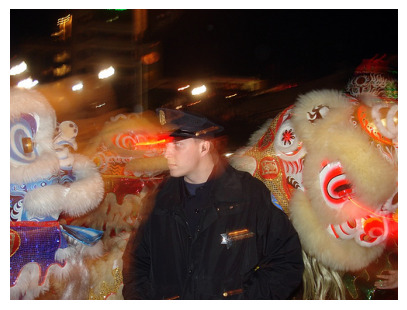


📝 YAPAY ZEKA TAHMİNİ: man in red costume is standing in front of crowd of people
--------------------------------------------------


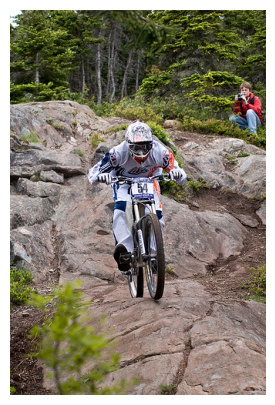


📝 YAPAY ZEKA TAHMİNİ: two people are riding their bikes uphill
--------------------------------------------------


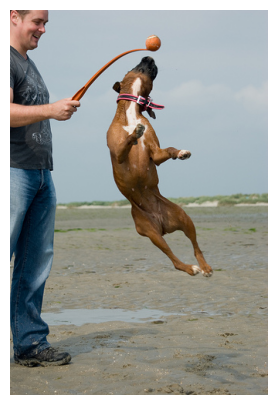


📝 YAPAY ZEKA TAHMİNİ: man in blue shirt is standing on the beach
--------------------------------------------------


In [6]:
import random  # <--- Eksik olan parça buydu
import os

def sansli_kutu(adet=3):
    print(f"🎲 {adet} Tane Rastgele Resim Seçiliyor...\n")

    # Klasördeki tüm resimleri listele
    # (RESIM_KLASORU değişkeni önceki hücreden geliyor, o hücreyi çalıştırdın varsayıyorum)
    tum_resimler = os.listdir(RESIM_KLASORU)
    jpg_resimler = [f for f in tum_resimler if f.endswith('.jpg')]

    # Rastgele seç
    secilenler = random.sample(jpg_resimler, adet)

    for dosya in secilenler:
        tam_yol = os.path.join(RESIM_KLASORU, dosya)
        test_et(tam_yol)

# Testi Başlat
sansli_kutu(3)